In [0]:
from operator import itemgetter
from typing import List

import requests


def get_titles(gsrsearch: str, limit: int = 5) -> List[str]:
    url = "https://en.wikipedia.org/w/api.php"
    params = {
        'action': 'query',
        'generator': 'search',
        'origin': '*',
        'gsrsearch': {gsrsearch},
        'format': 'json',
        'gsrlimit': f'{limit}'
    }
    session = requests.Session()
    req = session.get(url=url, params=params)
    data = req.json()
    titles_list = list(map(
        itemgetter("title"),
        data["query"]["pages"].values()
    ))
    return titles_list

In [0]:
import re
from typing import Optional

import bs4


def get_redirect(title) -> Optional[str]:
    session = requests.Session()
    url = f"https://wikipedia.org/wiki/{title}"
    req = session.get(url=url)
    if not req.ok:
        return None
    soup = bs4.BeautifulSoup(req.text, features="lxml")
    body_content = soup.find("div", id="bodyContent")
    tag_a = body_content.find('a', {
        "class": "mw-redirect",
        "href": re.compile("^/wiki/*")
    })
    return tag_a.string if tag_a else None


In [0]:
from collections import namedtuple


RedirectEdge = namedtuple(
    'RedirectEdge', [
        'from_vertex',
        'to_vertex',
        'type',
        'depth'
    ]
)

In [0]:
class RedirectGraph:

    def __init__(self):
        self.__history = set()
        self.__redirects = []

    def __contains__(self, item):
        return item in self.__history

    def append(self, redirect_edge: RedirectEdge):
        self.__redirects.append(redirect_edge)

    def register(self, vertex):
        self.__history.add(vertex)

    @property
    def edges(self):
      return self.__redirects

In [0]:
from collections import deque

import time


def traverse(entry_title: str, limit: int = 1, stop_word: str = "philosophy"):
    queue = deque(list(map(
        lambda title_nm: (0, title_nm),
        get_titles(entry_title, limit)
    )))
    redirect_graph = RedirectGraph()
    while queue:
        step, title = queue.popleft()
        print(f"{step}: {title}")
        redirect_title = get_redirect(title)
        if step == 0 and redirect_title is None:
            queue.append((0, get_titles(entry_title, 1)[0]))
        elif redirect_title is None:
            print(f"[NO REDIRECT]: {title}")
            redirect_graph.append(RedirectEdge(
                from_vertex=title,
                to_vertex=title,
                type='DEAD_END',
                depth=step
            ))
            continue
        elif re.search(stop_word, redirect_title.strip().lower()):
            print(f"[FINISH]: {redirect_title}")
            redirect_graph.register(redirect_title)
            redirect_graph.append(RedirectEdge(
                from_vertex=title,
                to_vertex=redirect_title,
                type='FINISH',
                depth=step+1
            ))
            return step + 1, redirect_graph
        elif redirect_title in redirect_graph:
            print(f"[CYCLED]: {redirect_title}")
            redirect_graph.append(RedirectEdge(
                from_vertex=title,
                to_vertex=redirect_title,
                type='CYCLE',
                depth=step+1
            ))
        else:
            if step == 0:
                redirect_graph.register(title)
            redirect_graph.register(redirect_title)
            redirect_graph.append(RedirectEdge(
                from_vertex=title,
                to_vertex=redirect_title,
                type='NORMAL',
                depth=step+1
            ))
            queue.append((step + 1, redirect_title))
        time.sleep(0.1)
    return -1, redirect_graph

In [0]:
try:
    import graphviz
except:
    import sys
    !{sys.executable} -m pip3 install graphviz
    import graphviz

In [0]:
def test(entry_title: str, limit: int = 1, stop_word: str = "philosophy"):
    depth, graph = traverse(entry_title, limit, stop_word)
    if depth == -1:
        print(f"{'>'*20}NO PHILOSOPHY{'<'*20}")
    else:
        print(f"{'>'*20}PHILOSOPHY REACHED AFTER {depth} STEPS{'<'*20}")
    graphics = graphviz.Digraph(
        'unix',
        node_attr={
            'color': 'lightblue2',
            'style': 'filled'
        },
        comment='Wiki traverse'
    )
    graphics.attr(size='12')
    for edge in graph.edges:
        graphics.edge(edge.from_vertex, edge.to_vertex, label=edge.type)
    return graphics

0: DC Universe
0: Expansion of the universe
0: Miss Universe
0: Observable universe
0: Steven Universe
0: Steven Universe Future
0: Universe
0: Universe (video game player)
0: Universe Championships
0: Universe Sandbox
1: List of DC Comics publications
1: Planck epoch
1: William Morris Endeavor
1: spherical
1: Action
[NO REDIRECT]: Action
1: 16:9
1: Latin
1: Indian American
1: Ray Routledge
1: Developer(s)
[NO REDIRECT]: Developer(s)
2: Tarzan
2: units of measurement
2: Beverly Hills
2: closed surface
2: Full HD
2: question marks, boxes, or other symbols
[NO REDIRECT]: question marks, boxes, or other symbols
2: New York Metropolitan Area
2: AAU Mr. America
3: Chieftain
3: Palazzo della Ragione
3: City
3: improve
3: HDTV
3: diplomatic
3: IFBB
[NO REDIRECT]: IFBB
4: Pantribal sodalities
[CYCLED]: Pantribal sodalities
4: medieval
4: transportation
4: land improvement
4: Blu-ray Discs
4: Benedictine
5: modern period
5: A380
5: earthmoving
5: High-density
5: Order of St. Benedict (Anglican)

[CYCLED]: paternity
>>>>>>>>>>>>>>>>>>>>NO PHILOSOPHY<<<<<<<<<<<<<<<<<<<<


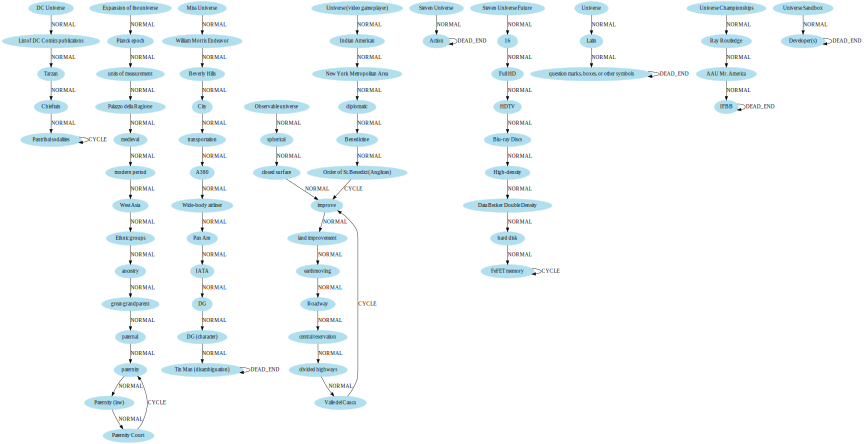

In [8]:
test("Universe", 10)

0: Master of Science
0: Political science
0: Science
0: Science (disambiguation)
0: Science (journal)
1: MS
1: Politics by country
[CYCLED]: Politics by country
1: predictions
1: Mathematical science
1: Science Journal (1965–71 magazine)
2: Master Sommelier
2: The Old Farmer's Almanac
2: academic disciplines
2: Reed Elsevier
3: Torquay, UK
3: Farmer's Almanac
3: academic
3: Reed Business Information
[CYCLED]: Reed Business Information
4: Police
4: Almanacs
4: Akademia
5: legitimized use of force
[NO REDIRECT]: legitimized use of force
5: Spanish Arabic
5: The Cave
6: Arabic
6: H2 (Canada)
7: L2 speakers
7: Séries+
8: native language
8: HDTV
9: Native Speaker (disambiguation)
[NO REDIRECT]: Native Speaker (disambiguation)
9: Blu-ray Discs
10: High-density
11: Data Becker Double Density
12: hard disk
13: FeFET memory
[CYCLED]: FeFET memory
>>>>>>>>>>>>>>>>>>>>NO PHILOSOPHY<<<<<<<<<<<<<<<<<<<<


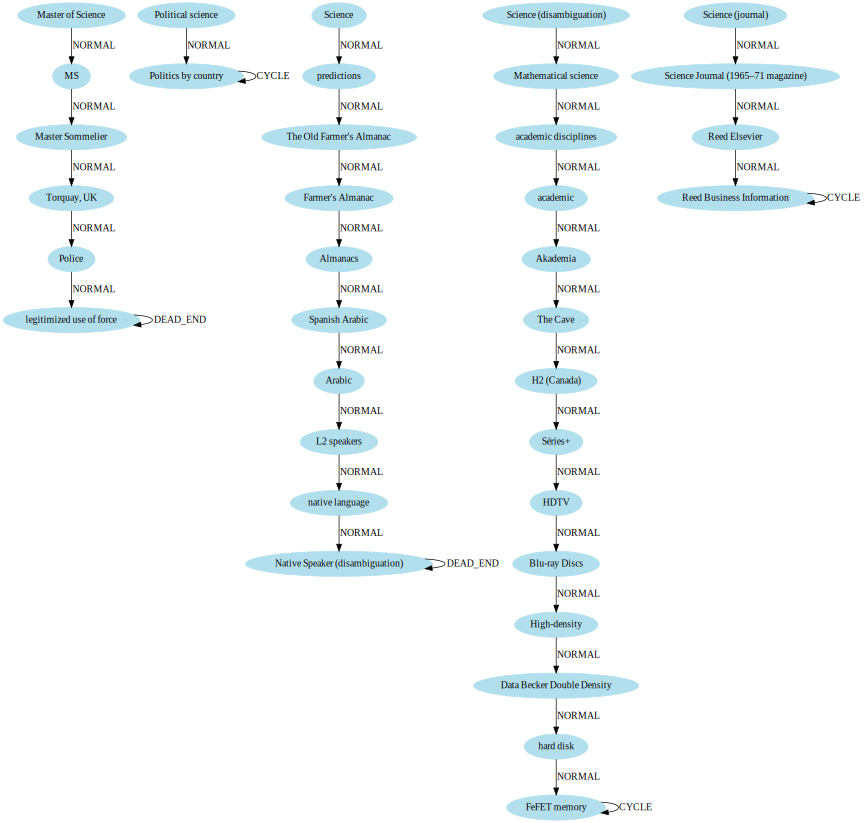

In [9]:
test("Science", 5)

0: Ancient Egypt
0: Ancient Greece
0: Ancient Greek
0: Ancient Rome
0: Ancient history
1: Dynasties
1: Greek Bronze Age
[CYCLED]: Greek Bronze Age
1: Greek (disambiguation)
1: Government
1: Antiquity (disambiguation)
2: Wikipedia style guidelines
[NO REDIRECT]: Wikipedia style guidelines
2: Mycenaean Greek language
2: improve
2: European Middle Ages
3: question marks, boxes, or other symbols
[NO REDIRECT]: question marks, boxes, or other symbols
3: land improvement
3: prehistory
[NO REDIRECT]: prehistory
4: earthmoving
5: Roadway
6: central reservation
7: divided highways
8: Valle del Cauca
[CYCLED]: improve
>>>>>>>>>>>>>>>>>>>>NO PHILOSOPHY<<<<<<<<<<<<<<<<<<<<


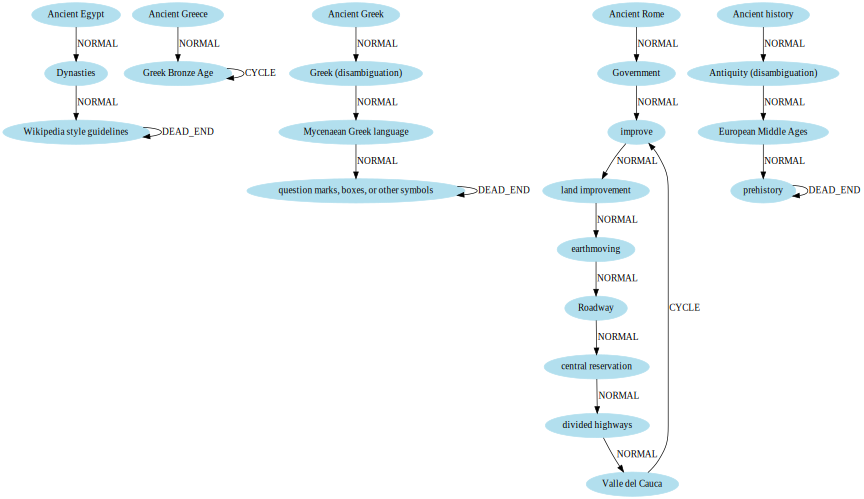

In [10]:
test("Ancient", 5)